In [1]:
import pandas as pd
import numpy as np


import os
import pickle

from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt


from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

In [5]:
# Load each dataset


breast = pd.read_csv('breast.tsv', sep='\t')
cervical = pd.read_csv('cervical.tsv', sep='\t')
brain = pd.read_csv('brain.tsv', sep='\t')
lung = pd.read_csv('lung.tsv', sep='\t')


lung_columns = [col for col in lung.columns if lung[col].astype(str).str.contains('LUAD').any()] + [col for col in lung.columns if lung[col].astype(str).str.contains('Lung').any()] + ["Study ID", "Sample ID"]
lung_columns.remove("Cancer Type")
lung = lung.drop(lung_columns, axis=1)
breast_columns = [col for col in breast.columns if breast[col].astype(str).str.contains('BRCA').any()] + [col for col in breast.columns if breast[col].astype(str).str.contains('Breast').any()] + ["Study ID", "Sample ID"]
breast_columns.remove("Cancer Type")
breast = breast.drop(breast_columns, axis=1)
cervical_columns = [col for col in cervical.columns if cervical[col].astype(str).str.contains('CESC').any()] + [col for col in cervical.columns if cervical[col].astype(str).str.contains('Cervical').any()] + ["Study ID", "Sample ID"]
cervical_columns.remove("Cancer Type")
cervical = cervical.drop(cervical_columns, axis=1)
brain_columns = [col for col in brain.columns if brain[col].astype(str).str.contains('GBM').any()] + [col for col in brain.columns if brain[col].astype(str).str.contains('Glioblastoma').any()] + ["Study ID", "Sample ID"]
brain_columns.remove("Cancer Type")
brain = brain.drop(brain_columns, axis=1)

#  Impute missing values with mean for each dataset
breast_imputed = breast.fillna(breast.mean())
cervical_imputed = cervical.fillna(cervical.mean())
brain_imputed = brain.fillna(brain.mean())
lung_imputed = lung.fillna(lung.mean())

# Impute missing values with mode for object-type columns for each dataset
breast_imputed = breast_imputed.apply(lambda x: x.fillna(x.mode()[0]) if x.dtype == 'object' else x, axis=0)
cervical_imputed = cervical_imputed.apply(lambda x: x.fillna(x.mode()[0]) if x.dtype == 'object' else x, axis=0)
brain_imputed = brain_imputed.apply(lambda x: x.fillna(x.mode()[0]) if x.dtype == 'object' else x, axis=0)
lung_imputed = lung_imputed.apply(lambda x: x.fillna(x.mode()[0]) if x.dtype == 'object' else x, axis=0)


combined_clinical = pd.concat([breast_imputed, cervical_imputed, brain_imputed, lung_imputed], axis=0)
print(combined_clinical.isnull().sum().sum())

ParserError: Error tokenizing data. C error: Expected 1 fields in line 9, saw 2


In [3]:
# Drop columns with too many missing values
filtered_combined_clinical = combined_clinical.dropna(thresh=0.6 * len(combined_clinical), axis=1)

# Separate categorical and numerical columns
categorical_columns = filtered_combined_clinical.select_dtypes(include=['object']).columns
numerical_columns = filtered_combined_clinical.select_dtypes(exclude=['object']).columns

# Label encode categorical variables
label_encoder = LabelEncoder()
for col in categorical_columns:
    filtered_combined_clinical[col] = label_encoder.fit_transform(filtered_combined_clinical[col])

# Impute missing values using KNN imputer
imputer = KNNImputer()
imputed_data = imputer.fit_transform(filtered_combined_clinical)

# Convert imputed data back to DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=filtered_combined_clinical.columns)

imputed_df.to_csv('processes.csv', index=False)

C:\Users\badda\AppData\Local\Temp\ipykernel_115472\3666004759.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_combined_clinical[col] = label_encoder.fit_transform(filtered_combined_clinical[col])


In [4]:

current_directory = os.getcwd()
node_fea = pd.read_csv('processes.csv')
node_fea = node_fea.to_numpy() # turn it into a ndarray

cosine_similarities = cosine_similarity(node_fea) # Compute cosine similarities
# pearson_correlation = np.corrcoef(node_fea)
cos_values = cosine_similarities.flatten()
mean_value = np.mean(cos_values)
median_value = np.median(cos_values)


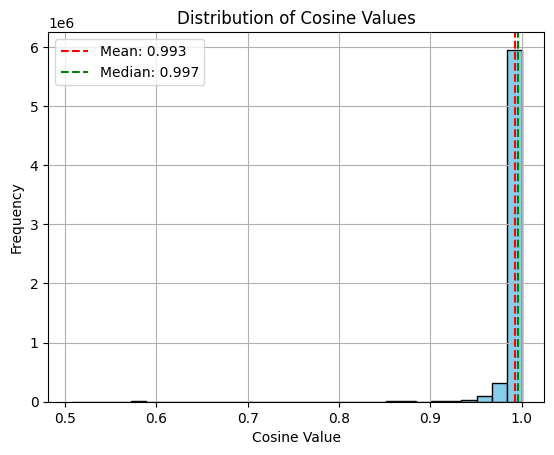

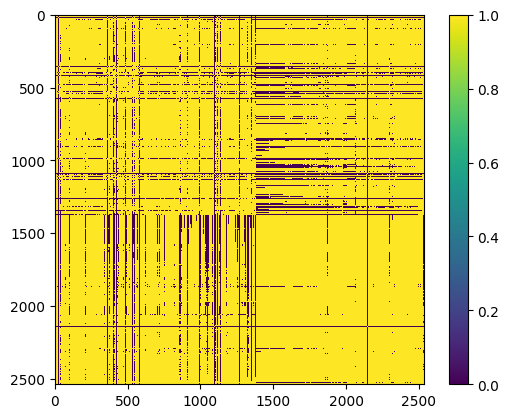

In [5]:
# Plot the histogram
plt.figure()
plt.hist(cos_values, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Cosine Values')
plt.xlabel('Cosine Value')
plt.ylabel('Frequency')
plt.grid(True)
# Annotate mean and median on the plot
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1.5,
label=f'Mean: {mean_value:.3f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=1.5,
label=f'Median: {median_value:.3f}')
plt.legend()
adjacency_mtx = cosine_similarities.copy()
# Set values less than the treshold to 0
adjacency_mtx[cosine_similarities < 0.99] = 0
# Set values greater than or equal to the treshold to 1
adjacency_mtx[cosine_similarities >= 0.99] = 1
plt.figure()
# Plot the heatmap
plt.imshow(adjacency_mtx, cmap='viridis', interpolation='nearest')
plt.colorbar() # Add color bar to show scale
plt.show()
with open('adj_mtx.pkl','wb') as f:
    pickle.dump(adjacency_mtx,f)

In [6]:
import pickle
import os
import matplotlib
# matplotlib.use('macosx')
import matplotlib.pyplot as plt
import torch
import pandas as pd
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch_geometric.data import Data
from scipy.sparse import csr_matrix
from sklearn.metrics import f1_score, accuracy_score
from torch_geometric.nn import GCNConv,GraphSAGE
import torch.nn.functional as F
from sklearn.model_selection import  train_test_split
import numpy as np
import statistics
import time

current_directory = os.getcwd()
with open('adj_mtx.pkl', 'rb') as f:
    adj_mtx = pickle.load(f)
# Convert the adjacency matrix to a sparse matrix
sparse_adj_matrix = csr_matrix(adj_mtx)
# Convert the sparse matrix to PyTorch Geometric data
edge_index = from_scipy_sparse_matrix(sparse_adj_matrix)[0]

node_fea = imputed_df.drop('Cancer Type', axis=1)
node_fea_tensor = torch.tensor(node_fea.values, dtype=torch.float32) #turn node attributes into torch tensor

labels = imputed_df["Cancer Type"]

data = Data(x=node_fea_tensor,
            edge_index=edge_index,
            y=torch.tensor(labels).long())

In [15]:

# Train-Validation split
alltrain_idx, test_idx = train_test_split(np.arange(len(labels)), test_size=0.2, shuffle=True, stratify=labels, random_state=0)
train_idx, val_idx = train_test_split(alltrain_idx, test_size=0.25, shuffle=True, stratify=labels[alltrain_idx], random_state=0)



In [16]:
class GCN(torch.nn.Module):
    def __init__(self, in_size1=4,hid_size1=2,out_size=2):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_size1, hid_size1)
        self.conv2 = GCNConv(hid_size1, hid_size1)
        self.conv3 = GCNConv(hid_size1, out_size)

    def forward(self, data):
        x1, edge_index1 = data.x, data.edge_index

        x_emb1 = F.relu(self.conv1(x1, edge_index1)) #first GCN layer
        x_emb1 = F.dropout(x_emb1, p=0.2, training=self.training) #dropout

        x_emb2 = F.relu(self.conv2(x_emb1, edge_index1)) #second GCN layer
        x_emb2 = F.dropout(x_emb2, p=0.2, training=self.training) #dropout

        x_emb3 = self.conv3(x_emb2, edge_index1) #final GCN layer
        return x_emb3

alltrain_idx, test_idx = train_test_split(np.arange(len(labels)), test_size=0.2, shuffle=True, stratify=labels,
                                           random_state=0)
train_idx, val_idx = train_test_split(alltrain_idx, test_size=0.25, shuffle=True,
                                          stratify=labels[alltrain_idx], random_state=0)



import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_size1=4, hid_size1=2, out_size=2, num_layers=2):
        super(GraphSAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        # Define GraphSAGE layers
        for i in range(self.num_layers):
            in_size = in_size1 if i == 0 else hid_size1
            out_size = out_size if i == self.num_layers - 1 else hid_size1
            self.convs.append(SAGEConv(in_size, out_size))
            self.bns.append(torch.nn.BatchNorm1d(out_size))

    def forward(self, data):
        x1, edge_index1 = data.x, data.edge_index

        # Apply GraphSAGE layers
        x = x1
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index1)
            x = self.bns[i](x)
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.2, training=self.training)

        return x




def train():
    model.train()
    optimizer.zero_grad()
    out1 = model(data)
    loss1 = criterion(out1[data.train_mask], data.y[data.train_mask])
    loss1.backward()
    optimizer.step()
    return out1,loss1

def validate():
    model.eval()
    with torch.no_grad():
        out1 = model(data)
        pred = (out1).argmax(dim=1)
        loss1 = criterion(out1[data.valid_mask], data.y[data.valid_mask])
    return pred,loss1



running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
acc: 0.237 std: 0.0
wf1: 0.097 std: 0.0
mf1: 0.11 std: 0.0
time: 5997.5 std: 0.0


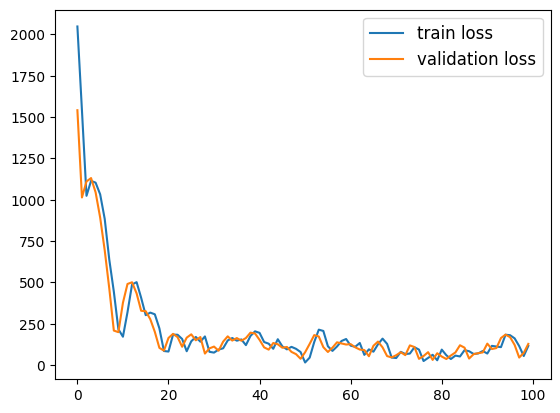

In [18]:
# Training parameters
max_epochs = 100
min_epochs = 70
patience = 50
xtimes1 = 50
xtimes2 = 10
learning_rates = [0.001]
hd_sizes = [64]
criterion = torch.nn.CrossEntropyLoss()
best_ValidLoss = np.Inf
in_size1 = data.x.shape[1]
out_size = torch.unique(data.y).shape[0]


av_result_acc = list()
av_result_wf1 = list()
av_result_mf1 = list()
av_time = list()

for learning_rate in learning_rates:
    for hd_size in hd_sizes:
        av_valid_losses = list()
        for ii in range(xtimes1):
            print('running..')
            start = time.time()
            model = GCN(in_size1=in_size1,hid_size1=hd_size,out_size=out_size)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            train_mask = np.array([i in set(train_idx) for i in range(data.x.shape[0])])
            data.train_mask = torch.tensor(train_mask)
            valid_mask = np.array([i in set(val_idx) for i in range(data.x.shape[0])])
            data.valid_mask = torch.tensor(valid_mask)
            min_valid_loss = np.Inf
            patience_count = 0
            TR_loss = list()
            Te_loss = list()
            for epoch in range(max_epochs):
                out,tr_loss = train()
                TR_loss.append(tr_loss)
                pred,this_valid_loss = validate()
                Te_loss.append(this_valid_loss)
                if this_valid_loss < min_valid_loss:
                    min_valid_loss = this_valid_loss
                    patience_count = 0
                else:
                    patience_count += 1

                if min_epochs<= epoch and patience_count >= patience:
                    break
            av_valid_losses.append(min_valid_loss.item())
        av_valid_loss = round(statistics.median(av_valid_losses), 3)

        if av_valid_loss < best_ValidLoss:
            best_ValidLoss = av_valid_loss
            best_lr = learning_rate
            best_emb_hs = hd_size
train_mask = np.array([i in set(train_idx) for i in range(data.x.shape[0])])
data.train_mask = torch.tensor(train_mask)
valid_mask = np.array([i in set(val_idx) for i in range(data.x.shape[0])])
data.valid_mask = torch.tensor(valid_mask)
result_acc = list()
result_wf1 = list()
result_mf1 = list()
for rns in range(xtimes2):
    model = GCN(in_size1=in_size1, hid_size1=best_emb_hs, out_size=out_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
    min_valid_loss = np.Inf
    patience_count = 0
    TR_loss = list()
    Te_loss = list()
    for epoch in range(max_epochs):
        out, tr_loss = train()
        TR_loss.append(tr_loss)
        pred, this_valid_loss = validate()
        Te_loss.append(this_valid_loss)
        if this_valid_loss < min_valid_loss:
            min_valid_loss = this_valid_loss
            patience_count = 0
        else:
            patience_count += 1

        if min_epochs <= epoch and patience_count >= patience:
            break
    valid_mask = np.array([i in set(test_idx) for i in range(data.x.shape[0])])
    data.valid_mask = torch.tensor(valid_mask)
    predictions, this_valid_loss = validate()
    y_test = labels[valid_mask]
    pred_ = predictions[valid_mask]
    result_acc.append(accuracy_score(labels[valid_mask], pred_))
    result_wf1.append(f1_score(labels[valid_mask], pred_, average='weighted'))
    result_mf1.append(f1_score(labels[valid_mask], pred_, average='macro'))
av_result_acc.append(np.median(result_acc))
av_result_wf1.append(np.median(result_wf1))
av_result_mf1.append(np.median(result_mf1))
end = time.time()
av_time.append(round(end - start, 1))

print('acc:',np.round(np.mean(av_result_acc),decimals=3),'std:',np.round(np.std(av_result_acc),decimals=3))
print('wf1:',np.round(np.mean(av_result_wf1),decimals=3),'std:',np.round(np.std(av_result_wf1),decimals=3))
print('mf1:',np.round(np.mean(av_result_mf1),decimals=3),'std:',np.round(np.std(av_result_mf1),decimals=3))
print('time:',np.round(np.mean(av_time),decimals=3),'std:',np.round(np.std(av_time),decimals=3))

train_loss = [tensor.item() for tensor in TR_loss]
val_loss = [tensor.item() for tensor in Te_loss]
plt.figure()
plt.plot(train_loss,label='train loss',linewidth=1.5)
plt.plot(val_loss,label='validation loss',linewidth=1.5)
plt.legend(fontsize=12)
plt.show()

running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
GraphSAGE Results:
acc: 0.486 std: 0.0
wf1: 0.507 std: 0.0
mf1: 0.172 std: 0.0
time: 2346.2 std: 0.0


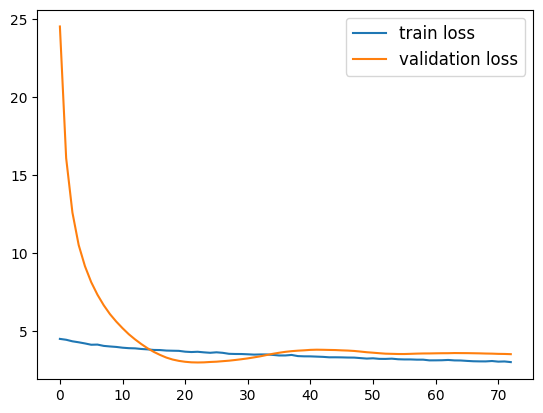

In [19]:


# Train-Validation split
alltrain_idx, test_idx = train_test_split(np.arange(len(labels)), test_size=0.2, shuffle=True, stratify=labels, random_state=0)
train_idx, val_idx = train_test_split(alltrain_idx, test_size=0.25, shuffle=True, stratify=labels[alltrain_idx], random_state=0)

# Training parameters
max_epochs = 100
min_epochs = 70
patience = 50
xtimes1 = 50
xtimes2 = 10
learning_rates = [0.001]
hd_sizes = [64]
criterion = torch.nn.CrossEntropyLoss()
best_ValidLoss = np.Inf
in_size = data.x.shape[1]
out_size = torch.unique(data.y).shape[0]

# List to store results
av_result_acc = []
av_result_wf1 = []
av_result_mf1 = []
av_time = []

# Loop over learning rates and hidden sizes
for learning_rate in learning_rates:
    for hd_size in hd_sizes:
        av_valid_losses = []
        for ii in range(xtimes1):
            print('running..')
            start = time.time()
            
            # Initialize model and optimizer
            model = GraphSAGE(in_size, hd_size, out_size)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            
            # Train-Validation split masks
            train_mask = np.array([i in set(train_idx) for i in range(data.x.shape[0])])
            data.train_mask = torch.tensor(train_mask)
            valid_mask = np.array([i in set(val_idx) for i in range(data.x.shape[0])])
            data.valid_mask = torch.tensor(valid_mask)
            
            # Initialize variables
            min_valid_loss = np.Inf
            patience_count = 0
            TR_loss = []
            Te_loss = []
            
            # Training loop
            for epoch in range(max_epochs):
                out, tr_loss = train()
                TR_loss.append(tr_loss)
                pred, this_valid_loss = validate()
                Te_loss.append(this_valid_loss)
                
                if this_valid_loss < min_valid_loss:
                    min_valid_loss = this_valid_loss
                    patience_count = 0
                else:
                    patience_count += 1

                if min_epochs <= epoch and patience_count >= patience:
                    break
            
            av_valid_losses.append(min_valid_loss.item())
        
        av_valid_loss = round(statistics.median(av_valid_losses), 3)

        if av_valid_loss < best_ValidLoss:
            best_ValidLoss = av_valid_loss
            best_lr = learning_rate
            best_emb_hs = hd_size

# Update train and valid masks
train_mask = np.array([i in set(train_idx) for i in range(data.x.shape[0])])
data.train_mask = torch.tensor(train_mask)
valid_mask = np.array([i in set(val_idx) for i in range(data.x.shape[0])])
data.valid_mask = torch.tensor(valid_mask)

# Testing
result_acc = []
result_wf1 = []
result_mf1 = []

for rns in range(xtimes2):
    # Initialize the model
    model = GraphSAGE(in_size, best_emb_hs, out_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
    
    # Initialize variables
    min_valid_loss = np.Inf
    patience_count = 0
    TR_loss = []
    Te_loss = []
    
    # Training loop
    for epoch in range(max_epochs):
        out, tr_loss = train()
        TR_loss.append(tr_loss)
        pred, this_valid_loss = validate()
        Te_loss.append(this_valid_loss)
        
        if this_valid_loss < min_valid_loss:
            min_valid_loss = this_valid_loss
            patience_count = 0
        else:
            patience_count += 1

        if min_epochs <= epoch and patience_count >= patience:
            break
    
    # Testing on the test set
    valid_mask = np.array([i in set(test_idx) for i in range(data.x.shape[0])])
    data.valid_mask = torch.tensor(valid_mask)
    predictions, this_valid_loss = validate()
    y_test = labels[valid_mask]
    pred_ = predictions[valid_mask]
    result_acc.append(accuracy_score(labels[valid_mask], pred_))
    result_wf1.append(f1_score(labels[valid_mask], pred_, average='weighted'))
    result_mf1.append(f1_score(labels[valid_mask], pred_, average='macro'))

# Store results
av_result_acc.append(np.median(result_acc))
av_result_wf1.append(np.median(result_wf1))
av_result_mf1.append(np.median(result_mf1))
end = time.time()
av_time.append(round(end - start, 1))

# Print results
print('GraphSAGE Results:')
print('acc:', np.round(np.mean(av_result_acc), decimals=3), 'std:', np.round(np.std(av_result_acc), decimals=3))
print('wf1:', np.round(np.mean(av_result_wf1), decimals=3), 'std:', np.round(np.std(av_result_wf1), decimals=3))
print('mf1:', np.round(np.mean(av_result_mf1), decimals=3), 'std:', np.round(np.std(av_result_mf1), decimals=3))
print('time:', np.round(np.mean(av_time), decimals=3), 'std:', np.round(np.std(av_time), decimals=3))

# Plot losses
train_loss = [tensor.item() for tensor in TR_loss]
val_loss = [tensor.item() for tensor in Te_loss]
plt.figure()
plt.plot(train_loss, label='train loss', linewidth=1.5)
plt.plot(val_loss, label='validation loss', linewidth=1.5)
plt.legend(fontsize=12)
plt.show()


running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
running..
GIN Results:
acc: 0.007 std: 0.0
wf1: 0.014 std: 0.0
mf1: 0.006 std: 0.0
time: 2482.0 std: 0.0


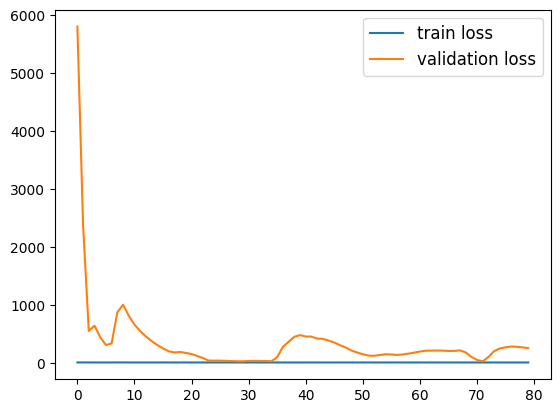

In [20]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv

class GIN(torch.nn.Module):
    def __init__(self, in_size1=4, hid_size1=2, out_size=2, num_layers=2):
        super(GIN, self).__init__()
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        # Define GIN layers
        for i in range(self.num_layers):
            in_size = in_size1 if i == 0 else hid_size1
            out_size = out_size if i == self.num_layers - 1 else hid_size1
            self.convs.append(GINConv(torch.nn.Sequential(
                torch.nn.Linear(in_size, hid_size1),
                torch.nn.ReLU(),
                torch.nn.Linear(hid_size1, hid_size1),
                torch.nn.ReLU()
            )))
            self.bns.append(torch.nn.BatchNorm1d(out_size))

    def forward(self, data):
        x1, edge_index1 = data.x, data.edge_index

        # Apply GIN layers
        x = x1
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index1)
            x = self.bns[i](x)
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.2, training=self.training)

        return x



# List to store results
av_result_acc = []
av_result_wf1 = []
av_result_mf1 = []
av_time = []

# Loop over learning rates and hidden sizes
for learning_rate in learning_rates:
    for hd_size in hd_sizes:
        av_valid_losses = []
        for ii in range(xtimes1):
            print('running..')
            start = time.time()
            
            # Initialize model and optimizer
            model = GIN(in_size, hd_size, out_size)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            
            # Train-Validation split masks
            train_mask = np.array([i in set(train_idx) for i in range(data.x.shape[0])])
            data.train_mask = torch.tensor(train_mask)
            valid_mask = np.array([i in set(val_idx) for i in range(data.x.shape[0])])
            data.valid_mask = torch.tensor(valid_mask)
            
            # Initialize variables
            min_valid_loss = np.Inf
            patience_count = 0
            TR_loss = []
            Te_loss = []
            
            # Training loop
            for epoch in range(max_epochs):
                out, tr_loss = train()
                TR_loss.append(tr_loss)
                pred, this_valid_loss = validate()
                Te_loss.append(this_valid_loss)
                
                if this_valid_loss < min_valid_loss:
                    min_valid_loss = this_valid_loss
                    patience_count = 0
                else:
                    patience_count += 1

                if min_epochs <= epoch and patience_count >= patience:
                    break
            
            av_valid_losses.append(min_valid_loss.item())
        
        av_valid_loss = round(statistics.median(av_valid_losses), 3)

        if av_valid_loss < best_ValidLoss:
            best_ValidLoss = av_valid_loss
            best_lr = learning_rate
            best_emb_hs = hd_size

# Update train and valid masks
train_mask = np.array([i in set(train_idx) for i in range(data.x.shape[0])])
data.train_mask = torch.tensor(train_mask)
valid_mask = np.array([i in set(val_idx) for i in range(data.x.shape[0])])
data.valid_mask = torch.tensor(valid_mask)

# Testing
result_acc = []
result_wf1 = []
result_mf1 = []

for rns in range(xtimes2):
    # Initialize the model
    model = GIN(in_size, best_emb_hs, out_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
    
    # Initialize variables
    min_valid_loss = np.Inf
    patience_count = 0
    TR_loss = []
    Te_loss = []
    
    # Training loop
    for epoch in range(max_epochs):
        out, tr_loss = train()
        TR_loss.append(tr_loss)
        pred, this_valid_loss = validate()
        Te_loss.append(this_valid_loss)
        
        if this_valid_loss < min_valid_loss:
            min_valid_loss = this_valid_loss
            patience_count = 0
        else:
            patience_count += 1

        if min_epochs <= epoch and patience_count >= patience:
            break
    
    # Testing on the test set
    valid_mask = np.array([i in set(test_idx) for i in range(data.x.shape[0])])
    data.valid_mask = torch.tensor(valid_mask)
    predictions, this_valid_loss = validate()
    y_test = labels[valid_mask]
    pred_ = predictions[valid_mask]
    result_acc.append(accuracy_score(labels[valid_mask], pred_))
    result_wf1.append(f1_score(labels[valid_mask], pred_, average='weighted'))
    result_mf1.append(f1_score(labels[valid_mask], pred_, average='macro'))

# Store results
av_result_acc.append(np.median(result_acc))
av_result_wf1.append(np.median(result_wf1))
av_result_mf1.append(np.median(result_mf1))
end = time.time()
av_time.append(round(end - start, 1))

# Print results
print('GIN Results:')
print('acc:', np.round(np.mean(av_result_acc), decimals=3), 'std:', np.round(np.std(av_result_acc), decimals=3))
print('wf1:', np.round(np.mean(av_result_wf1), decimals=3), 'std:', np.round(np.std(av_result_wf1), decimals=3))
print('mf1:', np.round(np.mean(av_result_mf1), decimals=3), 'std:', np.round(np.std(av_result_mf1), decimals=3))
print('time:', np.round(np.mean(av_time), decimals=3), 'std:', np.round(np.std(av_time), decimals=3))

# Plot losses
train_loss = [tensor.item() for tensor in TR_loss]
val_loss = [tensor.item() for tensor in Te_loss]
plt.figure()
plt.plot(train_loss, label='train loss', linewidth=1.5)
plt.plot(val_loss, label='validation loss', linewidth=1.5)
plt.legend(fontsize=12)
plt.show()